# Countering Sample Bias

## Introduction

This notebook will illustrate how to estimate performance using a baised sample. This is regarding the statistical of notion biased in the sense that a sample is not representative of the data at large. For example, if you are aggregating several surveys from different regions of a country and want to draw conclusions about the population of the entire country, you may wish to assign different weights to different surveys depending on the proportion of the population within the region the survey addressed and the number of people that answered the survey.

## Example Data

Let's say we have two regions and two surveys. All surveys asked the same questions:

1. What is your age?
2. How many years of education do you have?

We want to build a model that predicts number of years of education given age for people throughout the country. However, the country's population is split as follows:

* Region 1: 80%
* Region 2: 20%

Each survey had different proportions of respondants from different regions of the country, and different total numbers of respondants. We can't generally just combine all the survey results because they wouldn't generally be representative of the population as a whole. However, we can assign _weights_ to respondents in such a way that we can simulate the effect of a representative population given the proportions of respondants of each survey from each region.

In [1]:
import numpy
import pandas
from scipy.special import expit

data = []
total = 4 * 10 ** 6 # 4 million people in country
regional_proportions = (.8, .2)
for region, prop in enumerate(regional_proportions, start=1):
    n = int(total * prop)
    nprng = numpy.random.RandomState(region)
    age = nprng.uniform(18, 100, size=2 * n)
    demographic_offset = nprng.exponential(5)
    p = 1 - expit((age - 18) / 100 * demographic_offset)
    p /= p.sum()
    # rejection sample elder population to make more realistic age distribution
    age = nprng.choice(age, replace=False, size=n, p=p) 
    
    education_offset = nprng.normal(0, 10)
    slope = (20 + education_offset) / (100 - 18)
    noise = nprng.normal(0, 3, size=n)
    education = (age - 18) * slope + noise
    education[education < 0] = 0
    data.append(pandas.DataFrame({'age': age,
                                  'education': education.round(),
                                  'region': region}))
population = pandas.concat(data)
population

age  education  region
0       22.028976        0.0       1
1       44.912114        8.0       1
2       26.045553        3.0       1
3       31.072699        2.0       1
4       43.903140       12.0       1
...           ...        ...     ...
799995  80.995531        1.0       2
799996  54.082933        3.0       2
799997  35.139835        0.0       2
799998  80.768232        3.0       2
799999  60.227129        0.0       2

[4000000 rows x 3 columns]

## Visualization

As you can see below, different regions have different age and education distributions. They also have slightly different relationships between age and education.

<Figure size 640x480 with 0 Axes>

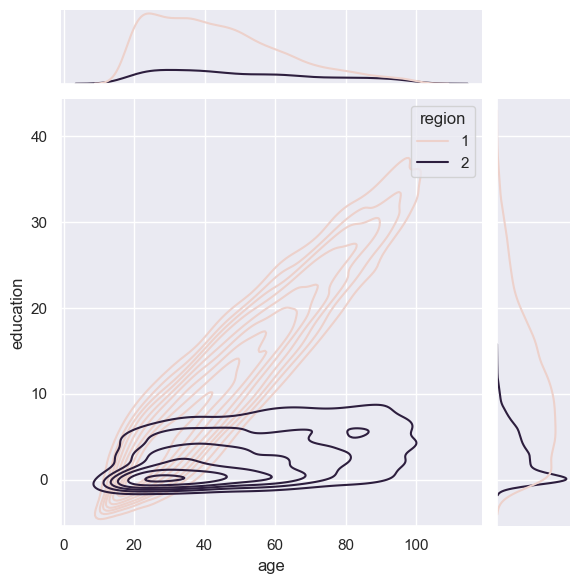

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

plt.clf()
sns.set_theme()

sns.jointplot(data=population.sample(10000, replace=False, random_state=0),
              x="age",
              y="education",
              hue="region",
              kind="kde")
plt.show()

## Survey Data

While we don't know exactly which respondent was from what region, we know the proportions of respondents in each of our four surveys.

In [3]:
n_respondents = (20000, 10000)
survey_proportions = numpy.asarray(
    [
        [0.2, 0.8], # survey 1 region proportions
        [0.5, 0.5], # survey 2 region proportions
    ])
print(survey_proportions.sum(1)) # each set of proportions sum to 1

random_state = 0
surveys = []
for survey, n_sample in enumerate((survey_proportions.T * n_respondents).T.astype('int'), start=1):
    survey_data = []
    for region, region_population in population.groupby('region'):
        region_sample = region_population.sample(n=n_sample[region - 1],
                                                 replace=False,
                                                 random_state=random_state)
        survey_data.append(region_sample)
        random_state += 1
    survey_data = pandas.concat(survey_data)
    survey_data['survey'] = survey
    surveys.append(survey_data)
sample_data = pandas.concat(surveys)

# assume no one answered any surveys more than once
sample_data = sample_data.sample(frac=1.)
sample_data = sample_data.loc[~sample_data.index.duplicated()]
not_sampled = population[~population.index.isin(sample_data.index)]

# surveyed respondents comprise a negligible proportion to the entire population
print(len(sample_data) / len(population))
sample_data

[1. 1.]
0.00746125


age  education  region  survey
570896   90.032094       10.0       2       1
1908479  40.606486       14.0       1       2
587338   40.794540        2.0       2       2
1564287  26.087168        0.0       1       1
728612   95.867544        2.0       2       1
...            ...        ...     ...     ...
750767   67.466088        6.0       2       1
671308   29.609484        1.0       2       1
229642   24.379894        0.0       2       1
2139865  18.579931        1.0       1       2
632943   47.067253        2.0       2       1

[29845 rows x 4 columns]

In [4]:
# The surveyed population isn't representative of
# the population at large
region_proportions = pandas.DataFrame((
    population['region'].value_counts(normalize=True).rename('General Population'),
    sample_data['region'].value_counts(normalize=True).rename('Surveyed Population'))).sort_index().T
region_proportions

General Population  Surveyed Population
1                 0.8             0.300385
2                 0.2             0.699615

In [5]:
sample_data

age  education  region  survey
570896   90.032094       10.0       2       1
1908479  40.606486       14.0       1       2
587338   40.794540        2.0       2       2
1564287  26.087168        0.0       1       1
728612   95.867544        2.0       2       1
...            ...        ...     ...     ...
750767   67.466088        6.0       2       1
671308   29.609484        1.0       2       1
229642   24.379894        0.0       2       1
2139865  18.579931        1.0       1       2
632943   47.067253        2.0       2       1

[29845 rows x 4 columns]

The surveys are varying mixtures of regional populations

<Figure size 640x480 with 0 Axes>

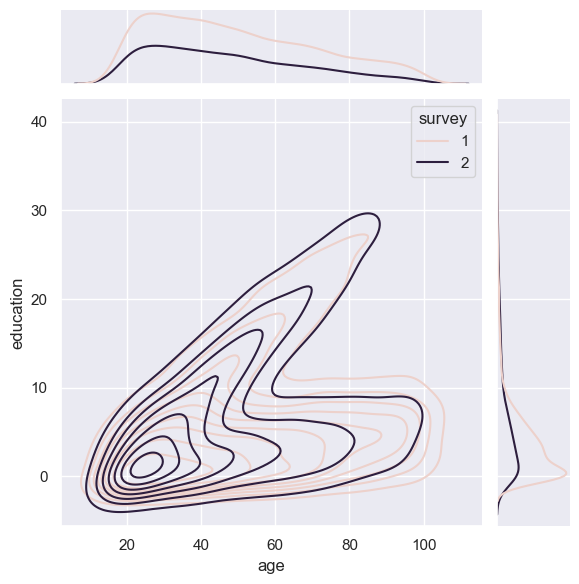

In [6]:
import seaborn as sns
import matplotlib.pylab as plt

plt.clf()
sns.set_theme()

sns.jointplot(data=sample_data.sample(10000, replace=False, random_state=0),
              x="age",
              y="education",
              hue="survey",
              kind="kde")
plt.show()

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = sample_data[['age']]
y = sample_data['education']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=0)
print(len(y_train), len(y_test))
model = LinearRegression().fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test))

19845 10000


33.079620678470135

In [8]:
# Since the survey data is not representative of the general population
# it performs much worse in production than it did on a validation set
X_real_world = not_sampled[['age']]
y_real_world = not_sampled['education']
mean_squared_error(y_real_world, model.predict(X_real_world))

63.30372141991118

## Reweighing Survey Data

Given the proportions of respondents from each region in each of our surveys, we can derive weights that can be used to compensate for sample bias and give us a more realistic picture of the real world. In this example, we are computing the expected sqaured loss

$L(\mathrm{edu}, \mathrm{edu}_\mathrm{pred}) = (\mathrm{edu}-\mathrm{edu}_\mathrm{pred})^2$.

$\mathbb{E}_{\mathrm{edu, region}\sim \mathrm{country}}L(\mathrm{edu},\mathrm{edu}_\mathrm{pred})
=\underset{\mathrm{edu},\mathrm{region} \in \mathrm{country}}{\sum}L(\mathrm{edu},\mathrm{edu}_\mathrm{pred})P(\mathrm{edu},\mathrm{region})$

$=\underset{\mathrm{edu},\mathrm{region} \in \mathrm{country}}{\sum}L(\mathrm{edu},\mathrm{edu}_\mathrm{pred})P(\mathrm{edu},\mathrm{region})\frac{P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})}{P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})}$

$=\underset{\mathrm{edu},\mathrm{region} \in \mathrm{country}}{\sum}L(\mathrm{edu},\mathrm{edu}_\mathrm{pred})P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})\frac{P(\mathrm{edu},\mathrm{region})}{P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})}$

Assuming we have nonzero probability of surveying anyone,


$=\underset{\mathrm{edu},\mathrm{region} \in \mathrm{surveyed}}{\sum}L(\mathrm{edu},\mathrm{edu}_\mathrm{pred})P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})\frac{P(\mathrm{edu},\mathrm{region})}{P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})}$

$=\mathbb{E}_{\mathrm{edu, region}\sim \mathrm{surveyed}}L(\mathrm{edu},\mathrm{edu}_\mathrm{pred})\frac{P(\mathrm{edu},\mathrm{region})}{P(\mathrm{edu},\mathrm{region}|\mathrm{surveyed})}$

Since the act of surveying does not affect the relationship between region and edu, we have $P(\mathrm{edu}|\mathrm{region})=P(\mathrm{edu}|\mathrm{region}, \mathrm{surveyed})$.

Equivalently

$\frac{P(\mathrm{edu},\mathrm{region})}{P(\mathrm{region})}=\frac{P(\mathrm{edu},\mathrm{region}, \mathrm{surveyed})}{P(\mathrm{region}, \mathrm{surveyed})}=\frac{P(\mathrm{edu},\mathrm{region}| \mathrm{surveyed})P(\mathrm{surveyed})}{P(\mathrm{region}, \mathrm{surveyed})}$

Switching the right hand numerator and left hand denonimator,

$\frac{P(\mathrm{edu},\mathrm{region})}{P(\mathrm{edu},\mathrm{region}| \mathrm{surveyed})}=\frac{P(\mathrm{region})P(\mathrm{surveyed})}{P(\mathrm{region}, \mathrm{surveyed})}=\frac{P(\mathrm{region})}{P(\mathrm{region}|\mathrm{surveyed})}=\frac{P(\mathrm{surveyed})}{P(\mathrm{surveyed}|\mathrm{region})}$

So even though have only biased samples, we can get an unbiased estimate of an expectation over the true distribution by _reweighing_ our samples with a factor of $\frac{P(\mathrm{region})}{P(\mathrm{region}|\mathrm{surveyed})}=\frac{P(\mathrm{surveyed})}{P(\mathrm{surveyed}|\mathrm{region})}$.

The latter is related to the [Horvitz-Thompson estimator](https://en.wikipedia.org/wiki/Horvitz%E2%80%93Thompson_estimator). The idiot proof way of doing this within Pandas, however, would just involve using the first expression by joining up a ratio of `value_counts(normalize=True)`.

In [9]:
weights = region_proportions['General Population'] / region_proportions['Surveyed Population']
weights

1    2.663246
2    0.285872
dtype: float64

In [10]:
# merge weights into sample data
sample_data = sample_data.reset_index().merge(
    weights.rename('weights').reset_index().rename(columns={'index': 'region'})).set_index('index')

In [11]:
# We get a much better match with production error using our weights

mean_squared_error(y_test, model.predict(X_test), sample_weight=sample_data.loc[X_test.index, 'weights'])

63.784047570574224

## Maximizing Performance

Many machine learning APIs have an optional argument for sample weights. Scikit learn is pretty consistent about this. This allows us to train the model on a more realistic representation of production data, even if we have a biased sample. This is equivalent to (but more computationally efficient than) up or down sampling.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = sample_data[['age']]
y = sample_data['education']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=0)
print(len(y_train), len(y_test))
model = LinearRegression().fit(X_train, y_train, sample_weight=sample_data.loc[X_train.index, 'weights'])
mean_squared_error(y_test, model.predict(X_test), sample_weight=sample_data.loc[X_test.index, 'weights'])

19845 10000


32.25887465682426

In [13]:
# Real world performance is much better when
# the sample data accurately represents it!

X_real_world = not_sampled[['age']]
y_real_world = not_sampled['education']
mean_squared_error(y_real_world, model.predict(X_real_world))

32.61086998013287

## ROC AUC

It's less clear how to computed a weighted ROC AUC, but noting that ROC AUC is the probability that a randomly sampled positive would be ranked higher than a randomly sampled negative allows us to derive one readily using our weights. `mvtk.metrics.rank_auc` has an optional `weights` parameter that suffices for this use case.

Let's say we need to compute the probability someone has at least 12 years of education (such as a high school graduate).

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = sample_data[['age']]
y = sample_data['education'] >= 12
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=0)
print(len(y_train), len(y_test))
model = MLPClassifier(hidden_layer_sizes=tuple()).fit(X_train, y_train)
roc_auc_score(y_test,
              model.predict_proba(X_test)[:, 1])

19845 10000


0.7371047314285715

In [15]:
X_real_world = not_sampled[['age']]
y_real_world = not_sampled['education'] >= 12
roc_auc_score(y_real_world,
              model.predict_proba(X_real_world)[:, 1])

0.8783547677682078

In [16]:
from mvtk.metrics import rank_auc

rank_auc(y_test.values,
         model.predict_proba(X_test)[:, 1],
         weights=sample_data.loc[X_test.index, 'weights'].values)

0.8825363120446511

## Acknowledgements
Thanks Mohammad Safarzadeh for reviewing many iterations of this derivation and example usage until they were rigorous and clear.